In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import line_data
from astropy import constants
import astropy.units as u
import pymoog

In [13]:
# Linelist compare

vald_1 = line_data.read_linelist('files/linelist/vald/vald_3000_11000.list')
vald_2 = line_data.read_linelist('files/linelist/vald/vald_11000_24000.list')
kurucz = line_data.read_linelist('files/linelist/kurucz/kurucz.list')
mb99_j = line_data.read_linelist('files/linelist/mb99/mb99_j.list')
mb99_k = line_data.read_linelist('files/linelist/mb99/mb99_k.list')
ges_no = line_data.read_linelist('files/linelist/ges/ges_hfs_iso.list')
gex_yes = line_data.read_linelist('files/linelist/ges/ges_nohfs_noiso.list')
apogee = line_data.read_linelist('files/linelist/apogee/apogee.list')

In [17]:
def get_linelist_info(linelist):
    wav = [min(linelist['wavelength']), max(linelist['wavelength'])]
    if len(linelist[linelist['id'] > 118]) > 0:
        molecular = True
    else:
        molecular = False
    num = len(linelist)
    return wav, molecular, num

In [19]:
ll_info = get_linelist_info(kurucz)
plt.plot()

([1000.016, 699991.22], False, 1930074)

In [11]:
s_ = pymoog.synth.synth(4500, 2.0, 0, 16000, 16100, 28000, line_list='vald_11000_24000')
s_.prepare_file()
s_.run_moog()
s_.read_spectra()

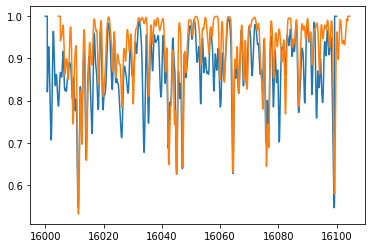

In [19]:
plt.plot(s.wav, s.flux)
plt.plot(s_.wav+4.5, s_.flux)